# TP Recalage altimétrique de navigation inertielle

## Luc de Montella, Joshua Wolff


Ce notebook présente la mise en place de divers filtres particulaires (SIR, SIS et adaptatif) ayant pour but de contrôler la trajectoire d'un avion à partir d'observations bruitées. On expliquera dans un premier temps pourquoi un recalage est nécessaire pour avoir une trajectoire acceptable, puis nous implémenterons plusieurs filtres afin de corriger la trajectoire de l'avion. Nous comparerons finalement ces différentes méthodes pour en identifier les avantages / inconvénients.

### Table des matières

* [Import des modules Python et déclaration des constantes](#chapter1)
* [Question I](#question1)
* [Question II](#question2)
* [Question III](#question3)
* [Question IV](#question4)
* [Question V](#question5)
* [Question VI](#question6)
* [Questions VII : Filtre particulaire SIR avec redistribution multinomiale](#question7)
* [Question VIII : Filtre particulaire SIS / avec redistribution adaptative](#question8)
* [Conclusion](#conclusion)

### Import des modules Python et déclaration des constantes <a class="anchor" id="chapter1"></a>

In [1]:
## Chemin d'accès aux données
import os
os.getcwd()
os.chdir(os.getcwd() + '/tan_data')

In [2]:
## Import des modules
import numpy as np # calcul numerique
import numpy.random as rnd # fonctions pseudo-aleatoires
import matplotlib.pyplot as plt # fonctions graphiques
import matplotlib.animation as anim # fonctions d’animation
import scipy.io as io # fonctions pour l’ouverture des fichiers .mat de MATLAB
import math
from scipy import interpolate
from matplotlib import rc, animation
%matplotlib inline
rc('animation', html='html5')

In [3]:
## Affectations des constantes du problème
X1MIN, X1MAX, X2MIN, X2MAX = -10000, 10000, -10000, 10000
r0 = np.array([-6000, 2000])
v0 = np.array([120, 0])
delta = 1
T = 100
sigma_r0 = 100
sigma_v0 = 10
sigma_INS = 7
sigma_ALT = 10
sigma_BAR = 20

In [4]:
## Import des données
maps = io.loadmat('mnt.mat')['map']
N1 = maps.shape[1]
N2 = maps.shape[0]

### Question 1 <a class="anchor" id="question1"></a>

On affiche dans un premier temps la position horizontale exacte de l'avion pour une trajectoire donnée, sur une carte représentant le relief survolé. La trajectoire réelle est à une altitude $z=z_0$ constante, et à vitesse $v=v_0$ constante.

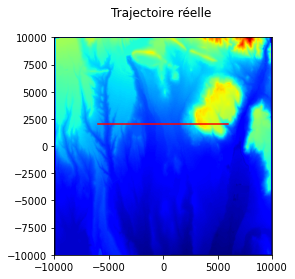

In [5]:
## Exemple de trajectoire
traj = io.loadmat('traj.mat')
rtrue = traj['rtrue']
vtrue = traj['vtrue']

## Affichage de la trajectoire
plt.imshow(maps, cmap = 'jet', extent = [X1MIN, X1MAX, X2MIN, X2MAX])
plt.plot(rtrue[0,:], rtrue[1,:], 'r-')
plt.title("Trajectoire réelle \n")
plt.show()

### Question II <a class="anchor" id="question2"></a>

À partir des mesures inertielles, de la position initiale $r_0$ et de la vitesse initiale $v_0$, on obtient l’estimation $r^{INS}$ de la position horizontale en intégrant les mesures d’accélération horizontale selon le modèle d'état suivant :

$$
\begin{pmatrix}
r_k^{INS} \\
v_k^{INS}
\end{pmatrix} =
\begin{pmatrix}
I_2 & \Delta I_2\\
0 & I_2
\end{pmatrix} 
\begin{pmatrix}
r_{k-1}^{INS} \\
v_{k-1}^{INS}
\end{pmatrix} + \Delta
\begin{pmatrix}
0 \\
a_k^{INS}
\end{pmatrix} \mbox{ avec }
\begin{pmatrix}
r_{0}^{INS} \\
v_{0}^{INS}
\end{pmatrix} = 
\begin{pmatrix}
r_{0} \\
v_{0}
\end{pmatrix} \mbox{ } (*)
$$

On trace finalement cette trajectoire sur la carte de l'espace survolé afin de la comparer avec la trajectoire réelle.

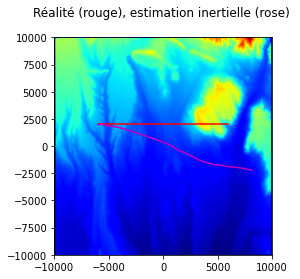

In [6]:
## Données mesures inertielles bruitées
a_INS = io.loadmat('ins.mat')['a_INS']

## Calcul de l'estimation inertielle de la position horizontale
r_INS = np.zeros(rtrue.shape)
v_INS = np.zeros(vtrue.shape)
r_INS[:,0] = r0
v_INS[:,0] = v0

for k in range(1,T+1):
    r_INS[:,k] = r_INS[:,k-1] + delta * v_INS[:,k-1]
    v_INS[:,k] = v_INS[:,k-1] + delta * a_INS[:,k-1]
    
## Affichage des trajectoires
plt.imshow(maps, cmap = 'jet', extent = [X1MIN, X1MAX, X2MIN, X2MAX])
plt.plot(rtrue[0,:], rtrue[1,:], 'r-')
plt.plot(r_INS[0,:], r_INS[1,:], 'm-')
plt.title("Réalité (rouge), estimation inertielle (rose) \n")
plt.show()

On observe une divergence très importante entre la trajectoire estimée et la trajectoire réelle. Les mesures inertielles étant bruité, l'erreur se cumule pendant notre schéma d'intégration, aboutissant à une trajectoire qui n'est absolument pas acceptable.

### Question III <a class="anchor" id="question3"></a>

On introduit comme nouvelle variable d'état les erreurs d'estimation inertielle $\delta r_k = r_k - r_k^{INS}$ sur la position horizontale et $\delta v_k = v_k - v_k^{INS}$ sur la vitesse horizontale. L'incertitude de mesure sur l'accélération horizontale est modélisée par un bruit blanc gaussien centré $w_k^{INS}$ de matrice de covariance $\sigma^2_{INS}I_2$, de tel sorte que $w_k^{INS} = a_k^{INS} - a_k$ avec $a_k$ l'accélération horizontale réelle. 

Le modèle d'état correspondant à ces nouvelles variables d'état est obtenu en remplaçant $r_k$ par $\delta r_k$, $v_k$ par $\delta v_k$, et $a_k$ par $a_k - a_k^{INS} = -w_k^{INS}$ dans l'équation d'état $(*)$. On obtient alors le modèle suivant :

$$
\begin{pmatrix}
\delta r_k \\
\delta v_k
\end{pmatrix} =
\begin{pmatrix}
I_2 & \Delta I_2\\
0 & I_2
\end{pmatrix} 
\begin{pmatrix}
\delta r_{k-1} \\
\delta v_{k-1}
\end{pmatrix} - \Delta
\begin{pmatrix}
0 \\
w_k^{INS}
\end{pmatrix} \mbox{ avec }
\begin{pmatrix}
\delta r_{0} \\
\delta v_{0}
\end{pmatrix} = 
\begin{pmatrix}
0 \\
0
\end{pmatrix} \mbox{ } (**)
$$

### Question IV <a class="anchor" id="question4"></a>

Pour corriger la dérive de l’estimation inertielle $r^{INS}_k$ de la position horizontale par rapport à la position horizontale exacte $r_k$, on recueille une mesure $d^{ALT}_k$ de la hauteur de l’avion au–dessus du relief situé à la verticale avec une erreur additive modélisée par un bruit blanc gaussien centré de variance $\sigma_{ALT}^2$. On recueille également une mesure $z^{BAR}_k$ de l’altitude de l’avion, avec une erreur additive modélisée par un bruit blanc gaussien centré de variance $\sigma^2_{BAR}$. On affiche ci-dessous la hauteur du relief à la verticale de la position réelle de l'avion.

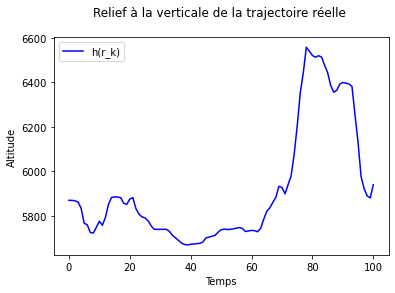

In [7]:
## Affichage du relief aux différents points r_k de la trajectoire réelle
N1 = maps.shape[1]
N2 = maps.shape[0]
PIX1 = (X1MAX-X1MIN)/N1
PIX2 = (X2MAX-X2MIN)/N2

i = np.floor((X2MAX-rtrue[1,:])/PIX2).astype(int)
j = np.floor((rtrue[0,:]-X1MIN)/PIX1).astype(int)

plt.plot(maps[i,j], 'b-', label = "h(r_k)")
plt.legend()
plt.xlabel("Temps")
plt.ylabel("Altitude")
plt.title("Relief à la verticale de la trajectoire réelle \n")
plt.show()

### Question V <a class="anchor" id="question5"></a>

On superpose désormais la hauteur du relief à la verticale de la position réelle de l'avion, avec la mesure bruitée $h^{ALT}_k$ issue des mesures de $d^{ALT}_k$ et $z^{BAR}_k$.

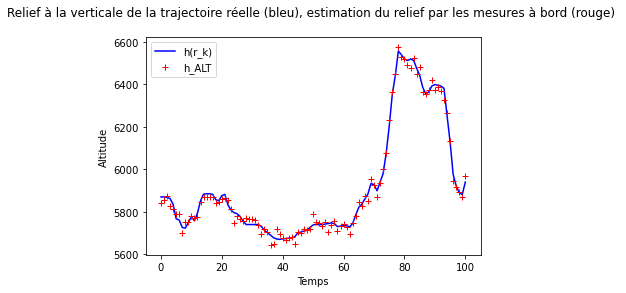

In [8]:
## Import des données
h_ALT = io.loadmat('alt.mat')['h_ALT'][0]
## Affichage du relief aux différents points r_k et des mesures bruitées du relief
plt.plot(maps[i,j], 'b-', label = "h(r_k)")
plt.plot(h_ALT, 'r+', label = "h_ALT")
plt.legend()
plt.xlabel("Temps")
plt.ylabel("Altitude")
plt.title("Relief à la verticale de la trajectoire réelle (bleu), estimation du relief par les mesures à bord (rouge) \n")
plt.show()

### Question VI <a class="anchor" id="question6"></a>

On sait que :

$$
d^{ALT}_k = z_k - h(r_k) +w_k^{ALT}
$$
$$
z_k^{BAR} = z_k w_k^{BAR}
$$
$$
h^{ALT}_k = z_k^{BAR} - d_k^{ALT} = h(r_k) + w_k^{BAR} - w_k^{ALT}
$$


On a par définition de $\delta r_k$, $r_k = r_k^{INS} + \delta r_k$, d'où :

$$
h^{ALT}_k = h(r_k^{INS} + \delta r_k) + w_k^{BAR} - w_k^{ALT}
$$

On peut alors déduire de ce résultat l'expression de la vraisemblance.

$$
g_k(r) = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{(h^{ALT}_k - h(r))^2}{2 \sigma^2}} \mbox{ avec } \sigma = \sqrt{\sigma_{BAR}^2 + \sigma_{ALT}^2}
$$

### Questions VII : Filtre particulaire SIR avec redistribution multinomiale <a class="anchor" id="question7"></a>

Nous pouvons finalement implémenter un filtre SIR, dans le but d'appliquer notre modèle d'états à des "particules" (i.e. des éléments de notre espace d'état) tout en les séléctionnant judicieusement à chaque incrément de temps au regard de leurs vraisemblances vis à vis des observations accessibles.

Plus précisément, l'algorithme SIR se décompose de la façon suivante :
- Distribution des $N$ particules dans l'espace d'état selon la loi initiale
- Application du modèle d'état au nuage de particules pour le "déplacer" (étape de mutation)
- Calcul des poids décrivant la vraisemblance des particules vis à vis des observations (étape de pondération)
- Pour chaque instant :
    - Redistribution multinomiale pour choisir les "bonnes" particules selon leurs poids respectifs (étape de sélection)
    - Application du modèle d'état au nouveau nuage de particules (étape de mutation)
    - Calcul des poids décrivant la vraisemblance des particules vis à vis des observations (étape de pondération)

La cellule ci-dessous contient les fonctions nécessaires à l'implémentation des différents filtres particulaires. Le filtre particulaire SIR est implémenté dans la cellule suivante.

In [9]:
## Calcul des poids pour un filtre particulaire SIR (étape de pondération)
def compute_w_SIR(y, x):
    
    h_k_ALT = y # observation
    
    i = np.floor((X2MAX-x[1,:])/PIX2).astype(int)
    j = np.floor((x[0,:]-X1MIN)/PIX1).astype(int)
    h_X = maps[i,j] # évalution de h(x) grâce à la carte
    
    sigma = np.sqrt(sigma_BAR**2 + sigma_ALT**2)
    g_k = 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-(h_k_ALT-h_X)**2/(2*sigma**2)) # calcul de la vraisemblance
    
    w = g_k / sum(g_k) # calcul des poids
    
    return w

## Calcul des poids pour un filtre particulaire SIS (étape de pondération)
def compute_w_SIS(y, x, w):
    
    h_k_ALT = y # observation
    
    i = np.floor((X2MAX-x[1,:])/PIX2).astype(int) 
    j = np.floor((x[0,:]-X1MIN)/PIX1).astype(int)
    
    # Empeche i et j de sortir de la map
    i = [min(x, maps.shape[0] - 1) for x in i]
    j = [min(x, maps.shape[1] - 1) for x in j]
    
    h_X = maps[i,j] # évalution de h(x) grâce à la carte
    
    sigma = np.sqrt(sigma_BAR**2 + sigma_ALT**2)
    g_k = 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-(h_k_ALT-h_X)**2/(2*sigma**2)) # calcul de la vraisemblance
    
    w = w*g_k / sum(w*g_k) # calcul des poids
    
    return w


## Definition d'une fonction donnant les indices des ancetres dans la redistribution multinomiale
def resampling_multi(w,N):
    u_tild = np.zeros((N))
    expo = np.zeros((N))
    alpha = np.zeros((N))
    u_ord = np.zeros((N))
    uu = np.zeros((N+1))
    s = np.zeros((N))

    w = w/w.sum()
    s = np.cumsum(w)
    u_tild = rnd.uniform(0,1,N)

    for i in range(N):
        alpha[i] = u_tild[i]**(1/float(i+1))
    alpha = np.cumprod(alpha)
    u_ord = alpha[N-1]/alpha
    u = np.append(u_ord,float("inf"))

    ancestor = np.zeros(N,dtype=int)
    offsprings = np.zeros(N,dtype=int)
    i = 0
    for j in range(N):
        o = 0
        while u[i]<=s[j]:
            ancestor[i] = j
            i = i+1
            o = o+1
        offsprings[j] = o
    return ancestor

In [10]:
#############################
## Filtre particulaire SIR ##
#############################


def filtre_sir(N):
    
    particles_r = np.zeros((2,N,T+1))
    particles_v = np.zeros((2,N,T+1))
    weights = np.zeros((N,T+1))

    # Tirage initial des particules
    particles_r[:,:,0] = rnd.multivariate_normal(np.zeros(2), sigma_r0 * np.identity(2), N).T
    particles_v[:,:,0] = rnd.multivariate_normal(np.zeros(2), sigma_v0 * np.identity(2), N).T

    # Calcul des poids (pondération)
    weights[:,0] = compute_w_SIR(h_ALT[0], r_INS[:,0].reshape(2,1) + particles_r[:,:,0])

    for k in range(1,T+1):
        indices = resampling_multi(weights[:,k-1],N) # Redistribution multinomiale (sélection)
        particles_r[:,:,k] = particles_r[:,indices,k-1] + delta * particles_v[:,indices,k-1] # Mutation
        particles_v[:,:,k] = particles_v[:,indices,k-1] + delta * rnd.multivariate_normal(np.zeros(2), sigma_INS * np.identity(2), N).T
        weights[:,k] = compute_w_SIR(h_ALT[k], r_INS[:,k].reshape(2,1) + particles_r[:,:,k]) # Pondération
    
    ## Affichage des trajectoires
    fig, ax = plt.subplots()
    line, = ax.plot([], 'k+') 
    res_part = np.zeros(particles_r.shape)
    for i in range(N):
        res_part[:,i,:] = r_INS
    res_part += particles_r # nuage de particules

    res_moy = r_INS + np.sum(weights * particles_r,1) # Estimation inertielle + moyenne pondérée des particules

    ax.imshow(maps, cmap = 'jet', extent = [X1MIN, X1MAX, X2MIN, X2MAX])
    ax.plot(r_INS[0,:], r_INS[1,:], 'm-')
    ax.plot(rtrue[0,:], rtrue[1,:], 'r-')
    ax.plot(res_moy[0,:], res_moy[1,:], 'y-')
    titre = "Réalité (rouge), estimation inertielle (rose)\nNuage particules (noir), moyenne pondérée (jaune) \nN = " + str(N) + " particules"
    
    def animate(frame_num):
        y = res_part[1, :, frame_num]
        x = res_part[0, : , frame_num]
        line.set_data((x, y))
        return line

    anim = animation.FuncAnimation(fig, animate, frames=T, interval=20)

    return titre, anim


In [ ]:
# Creation des animations

titre_100, anim_100 = filtre_sir(100)
titre_500, anim_500 = filtre_sir(500)
titre_1000, anim_1000 = filtre_sir(1000)
titre_5000, anim_5000 = filtre_sir(5000)

In [12]:
print(titre_100)
anim_100

Réalité (rouge), estimation inertielle (rose)
Nuage particules (noir), moyenne pondérée (jaune) 
N = 100 particules


In [13]:
print(titre_500)
anim_500

Réalité (rouge), estimation inertielle (rose)
Nuage particules (noir), moyenne pondérée (jaune) 
N = 500 particules


In [14]:
print(titre_1000)
anim_1000

Réalité (rouge), estimation inertielle (rose)
Nuage particules (noir), moyenne pondérée (jaune) 
N = 1000 particules


In [15]:
print(titre_5000)
anim_5000

Réalité (rouge), estimation inertielle (rose)
Nuage particules (noir), moyenne pondérée (jaune) 
N = 5000 particules


### Question VIII : Filtre particulaire SIS / avec redistribution adaptative <a class="anchor" id="question8"></a>

Pour mieux comprendre l'effet de l'échantillonnage préférentiel, nous allons implémenter un filtre SIS, dont le fonctionnement est similaire à un filtre SIR sans l'étape de sélection par redistribution multinomiale. Notons que l'expressions des poids ne dépend plus uniquement de la vraisemblance mais aussi des poids précédents.

In [16]:
#############################
## Filtre particulaire SIS ##
#############################

def filtre_sis(N): 
    particles_r = np.zeros((2,N,T+1))
    particles_v = np.zeros((2,N,T+1))
    weights = np.zeros((N,T+1))

    # Tirage initial
    particles_r[:,:,0] = rnd.multivariate_normal(np.zeros(2), sigma_r0 * np.identity(2), N).T
    particles_v[:,:,0] = rnd.multivariate_normal(np.zeros(2), sigma_v0 * np.identity(2), N).T

    # Calcul des poids (pondération)
    weights[:,0] = compute_w_SIR(h_ALT[0], r_INS[:,0].reshape(2,1) + particles_r[:,:,0]) # le premier calcul des poids se fait de la même façon que dans l'algorithme SIR

    for k in range(1,T+1):
        particles_r[:,:,k] = particles_r[:,:,k-1] + delta * particles_v[:,:,k-1] # Mutation
        particles_v[:,:,k] = particles_v[:,:,k-1] + delta * rnd.multivariate_normal(np.zeros(2), sigma_INS * np.identity(2), N).T
        weights[:,k] = compute_w_SIS(h_ALT[k], r_INS[:,k].reshape(2,1) + particles_r[:,:,k], weights[:,k-1]) # Pondération

    ## Affichage des trajectoires
    fig, ax = plt.subplots()
    line, = ax.plot([], 'k+') 
    res_part = np.zeros(particles_r.shape)
    for i in range(N):
        res_part[:,i,:] = r_INS
    res_part += particles_r # nuage de particules

    res_moy = r_INS + np.sum(weights * particles_r,1) # Estimation inertielle + moyenne pondérée des particules

    ax.imshow(maps, cmap = 'jet', extent = [X1MIN, X1MAX, X2MIN, X2MAX])
    ax.plot(r_INS[0,:], r_INS[1,:], 'm-')
    ax.plot(rtrue[0,:], rtrue[1,:], 'r-')
    ax.plot(res_moy[0,:], res_moy[1,:], 'y-')
    titre = "Réalité (rouge), estimation inertielle (rose) \n Nuage particules (noir), moyenne pondérée (jaune) \n N = " + str(N) + " particules \n"
    
    def animate(frame_num):
        y = res_part[1, :, frame_num]
        x = res_part[0, : , frame_num]
        line.set_data((x, y))
        return line

    anim = animation.FuncAnimation(fig, animate, frames=T, interval=20)

    return titre, anim


In [ ]:
titre_100, anim_100 = filtre_sis(100)
titre_500, anim_500 = filtre_sis(500)
titre_1000, anim_1000 = filtre_sis(1000)
titre_5000, anim_5000 = filtre_sis(5000)

In [18]:
print(titre_100)
anim_100

Réalité (rouge), estimation inertielle (rose) 
 Nuage particules (noir), moyenne pondérée (jaune) 
 N = 100 particules 



In [19]:
print(titre_500)
anim_500

Réalité (rouge), estimation inertielle (rose) 
 Nuage particules (noir), moyenne pondérée (jaune) 
 N = 500 particules 



In [20]:
print(titre_1000)
anim_1000

Réalité (rouge), estimation inertielle (rose) 
 Nuage particules (noir), moyenne pondérée (jaune) 
 N = 1000 particules 



In [21]:
print(titre_5000)
anim_5000

Réalité (rouge), estimation inertielle (rose) 
 Nuage particules (noir), moyenne pondérée (jaune) 
 N = 5000 particules 



On implémente désormais un filtre particulaire adaptatif, qui "combine" les deux filtres précédents. 

In [22]:
###################################
## Filtre particulaire adaptatif ##
###################################

def filtre_particulaire(N, c) :
    particles_r = np.zeros((2,N,T+1))
    particles_v = np.zeros((2,N,T+1))
    weights = np.zeros((N,T+1))
    Neff = np.zeros(T+1)

    # Tirage initial
    particles_r[:,:,0] = rnd.multivariate_normal(np.zeros(2), sigma_r0 * np.identity(2), N).T
    particles_v[:,:,0] = rnd.multivariate_normal(np.zeros(2), sigma_v0 * np.identity(2), N).T

    # Calcul des poids (pondération)
    weights[:,0] = compute_w_SIR(h_ALT[0], r_INS[:,0].reshape(2,1) + particles_r[:,:,0]) # le premier calcul des poids se fait de la même façon que dans l'algorithme SIR
    Neff[0] = 1/(np.sum(weights[:,0]**2))

    for k in range(1,T+1):
        if Neff[k-1] > c*N :
            particles_r[:,:,k] = particles_r[:,:,k-1] + delta * particles_v[:,:,k-1]
            particles_v[:,:,k] = particles_v[:,:,k-1] + delta * rnd.multivariate_normal(np.zeros(2), sigma_INS * np.identity(2), N).T
        else :
            indices = resampling_multi(weights[:,k-1],N)
            particles_r[:,:,k] = particles_r[:,indices,k-1] + delta * particles_v[:,indices,k-1]
            particles_v[:,:,k] = particles_v[:,indices,k-1] + delta * rnd.multivariate_normal(np.zeros(2), sigma_INS * np.identity(2), N).T
            weights[:,k-1] = 1/N
        
        weights[:,k] = compute_w_SIS(h_ALT[k], r_INS[:,k].reshape(2,1) + particles_r[:,:,k], weights[:,k-1])
        Neff[k] = 1/(np.sum(weights[:,k]**2))

    ## Affichage des trajectoires
    fig, ax = plt.subplots()
    line, = ax.plot([], 'k+') 
    res_part = np.zeros(particles_r.shape)
    for i in range(N):
        res_part[:,i,:] = r_INS
    res_part += particles_r # nuage de particules

    res_moy = r_INS + np.sum(weights * particles_r,1) # Estimation inertielle + moyenne pondérée des particules

    ax.imshow(maps, cmap = 'jet', extent = [X1MIN, X1MAX, X2MIN, X2MAX])
    ax.plot(r_INS[0,:], r_INS[1,:], 'm-')
    ax.plot(rtrue[0,:], rtrue[1,:], 'r-')
    ax.plot(res_moy[0,:], res_moy[1,:], 'y-')
    titre = "Réalité (rouge), estimation inertielle (rose)\nNuage particules (noir), moyenne pondérée (jaune) \nN = " + str(N) + " particules, c = " + str(c)
    
    def animate(frame_num):
        y = res_part[1, :, frame_num]
        x = res_part[0, : , frame_num]
        line.set_data((x, y))
        return line

    anim = animation.FuncAnimation(fig, animate, frames=T, interval=20)

    return titre, anim


In [ ]:
# Création des animations

titre_5000_00, anim_5000_00 = filtre_particulaire(5000, 0)
titre_5000_02, anim_5000_02 = filtre_particulaire(5000, 0.2)
titre_5000_04, anim_5000_04 = filtre_particulaire(5000, 0.4)
titre_5000_06, anim_5000_06 = filtre_particulaire(5000, 0.6)
titre_5000_08, anim_5000_08 = filtre_particulaire(5000, 0.8)

In [24]:
print(titre_5000_00)
anim_5000_00 

Réalité (rouge), estimation inertielle (rose)
Nuage particules (noir), moyenne pondérée (jaune) 
N = 5000 particules, c = 0


In [25]:
print(titre_5000_02)
anim_5000_02 

Réalité (rouge), estimation inertielle (rose)
Nuage particules (noir), moyenne pondérée (jaune) 
N = 5000 particules, c = 0.2


In [26]:
print(titre_5000_04)
anim_5000_04 

Réalité (rouge), estimation inertielle (rose)
Nuage particules (noir), moyenne pondérée (jaune) 
N = 5000 particules, c = 0.4


In [27]:
print(titre_5000_06)
anim_5000_06 

Réalité (rouge), estimation inertielle (rose)
Nuage particules (noir), moyenne pondérée (jaune) 
N = 5000 particules, c = 0.6


In [28]:
print(titre_5000_08)
anim_5000_08 

Réalité (rouge), estimation inertielle (rose)
Nuage particules (noir), moyenne pondérée (jaune) 
N = 5000 particules, c = 0.8


### Conclusion <a class="anchor" id="conclusion"></a>

Lors de ce TP, nous avons mis en place trois types de filtres particulaires pour répondre à un problème de recalage altimétrique de navigation inertielle. Cette mise en place se justifie par la divergence observée entre la position réel et la postion estimée en raison du bruit sur les mesures inertielles.

Le premier filtre mis en place a été le filtre SIR. L'étude liée à ce filtre a mis en évidence l'importance de la taille du nuge de particules. En effet, on observe que l'estimation s'améliore lorsque le nombre de particules augmente.

Le second filtre mis en place a été le filtre SIS. Contrairement au filtre SIR, il n'y pas d'étape de sélection des meilleures particules. Le fait de conserver les mauvaises particules a été source de problème lors du développement, puisque certaines d'entre elles pouvaient sortir de notre carte, et donc rendre impossible le fonctionnement de l'algorithme. Ceci nous a forcé à modifier 'manuellemement' certains tirages réalisés lors du processus.

Enfin, nous avons mis en place le filtre adaptatif qui combine les deux approches précédentes. Ce filtre a l'avantage de ne pas faire de rééchantillonages superflus, mais corrige tout de même le problème lié aux particules peu vraisemblables en autorisant sous certaines conditions un processus de sélection. On constate qu'en jouant sur le paramètre qui conditionne le rééchantillonage, on joue sur l'étalement du nuage de point. En effet, la variance du nuage diminue au fur et à mesure que le paramètre se rapproche de 1 (autrement dit, plus on fait de rééchantillonage, plus les particules sont proches les unes des autres).

Visuellement, sur les cas étudiés, il semble qu'un choix intermédiaire du paramètre de rééchantillonage donne de meilleures performances qu'un choix extrême (i.e proche de 1 ou de 0).